In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [2]:
df_train = pd.read_csv('F:/Titanic/data/train.csv')

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
def replace_age_fraction(df_train):
    df_train.loc[df_train['Age']<1,'Age'] = df_train.loc[df_train['Age']<1,'Age']*100
    print len(df_train.loc[df_train['Age']<1,'Age'])


In [5]:
def replace_na_to_mode(df_train):
    for i in df_train.columns:
    
        if(i in ['PassengerId','Name']):
            pass
        else:
            print i
            df_train[i]= df_train[i].fillna(df_train[i].mode()[0]) # fill na by mode Values

In [6]:
replace_age_fraction(df_train)


0


In [7]:
replace_na_to_mode(df_train)

Survived
Pclass
Sex
Age
SibSp
Parch
Ticket
Fare
Cabin
Embarked


### Create polynomial of column values

In [8]:
def polynomial_data(dataframe, column_name, power =1):
    tmp_df = pd.DataFrame()
    col_degree = [column_name+str(i) for i in range(1,power+1)]
    
    for i in range(1,power+1):
        tmp_df[col_degree[i-1]]=dataframe[column_name]**i
        
    return tmp_df

In [9]:
# gbm_model1 seems best for this setting with 84 validation error and 96.

df_poly = pd.concat([polynomial_data(df_train,'Pclass',2), 
                 polynomial_data(df_train,'Age',5),
                 polynomial_data(df_train,'Fare',4), 
                 df_train], axis=1)

In [10]:
# df_poly = pd.concat([polynomial_data(df_train,'Pclass',30), 
#                  polynomial_data(df_train,'Age',40),
#                  polynomial_data(df_train,'Fare',30), 
#                  df_train], axis=1)

In [11]:
import h2o

In [12]:
h2o.init(max_mem_size='6g')

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,1 day 6 hours 45 mins
H2O cluster version:,3.10.3.4
H2O cluster version age:,1 month and 3 days
H2O cluster name:,H2O_from_python_hamza_leg62c
H2O cluster total nodes:,1
H2O cluster free memory:,5.207 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [13]:
hdf = h2o.H2OFrame(df_poly)

hdf['Survived']= hdf['Survived'].asfactor()
hdf_train, hdf_validate = hdf.split_frame([0.70], seed=100)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [14]:
hdf.head(3)

Pclass1,Pclass2,Age1,Age2,Age3,Age4,Age5,Fare1,Fare2,Fare3,Fare4,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
3,9,22,484,10648,234256,5.15363e+06,7.25,52.5625,381.078,2762.82,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,nan,7.25,B96 B98,S
1,1,38,1444,54872,2.08514e+06,7.92352e+07,71.2833,5081.31,362212,2.58197e+07,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,nan,71.2833,C85,C
3,9,26,676,17576,456976,1.18814e+07,7.925,62.8056,497.735,3944.55,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,nan,7.925,B96 B98,S


In [15]:
input_col = hdf.col_names
input_col.remove('Survived')
print input_col

[u'Pclass1', u'Pclass2', u'Age1', u'Age2', u'Age3', u'Age4', u'Age5', u'Fare1', u'Fare2', u'Fare3', u'Fare4', u'PassengerId', u'Pclass', u'Name', u'Sex', u'Age', u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked']


In [16]:
from h2o.estimators.naive_bayes import H2ONaiveBayesEstimator

In [17]:
nb =H2ONaiveBayesEstimator(seed =1, nfolds=30)
nb.train(x =input_col, y = 'Survived', training_frame=hdf_train, validation_frame=hdf_validate)

naivebayes Model Build progress: |████████████████████████████████████████| 100%


Train accuracy: 0.766639036251
valid accuracy: 0.750683994528


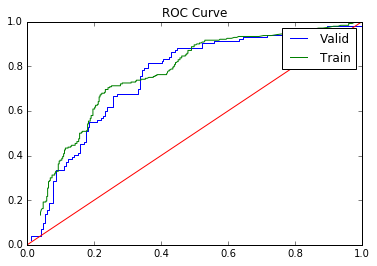

In [18]:
def model_performance(model =  nb):
    print 'Train accuracy:', model.auc(train=True)
    print 'valid accuracy:', model.auc(valid=True)

    roc_valid = model.roc(valid=True)
    roc_train= model.roc()

    plt.plot(roc_valid[0],roc_valid[1])
    plt.plot(roc_train[0],roc_train[1])
    plt.plot(np.arange(0.0,1.1,0.1),np.arange(0.0,1.1,0.1))
    
    plt.title('ROC Curve')
    plt.legend(['Valid','Train'])
    plt.show()

model_performance()

In [19]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [20]:
gbm_model = H2OGradientBoostingEstimator(seed =1,  ntrees = 200, learn_rate = .01 , distribution = 'AUTO')
gbm_model.train(x =input_col, y = 'Survived', training_frame=hdf_train, validation_frame=hdf_validate)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


Train accuracy: 0.954343501326
valid accuracy: 0.839346785226


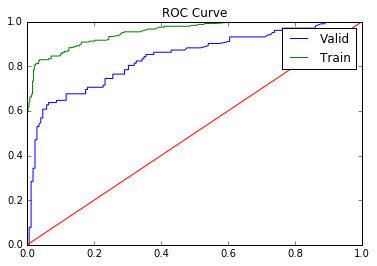

In [21]:
model_performance(gbm_model)

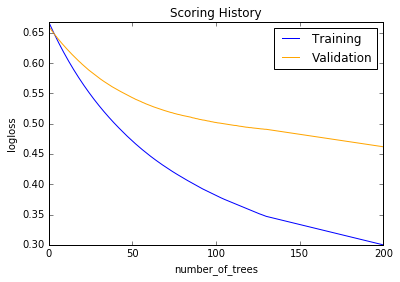

In [22]:
gbm_model.plot()

In [23]:
gbm_model1 = H2OGradientBoostingEstimator(seed =1,  ntrees = 15, learn_rate = .2003, distribution = 'AUTO', 
                                          build_tree_one_node = True)
gbm_model1.train(x =input_col, y = 'Survived', training_frame=hdf_train, validation_frame=hdf_validate)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


Train accuracy: 0.963682581786
valid accuracy: 0.847412220702


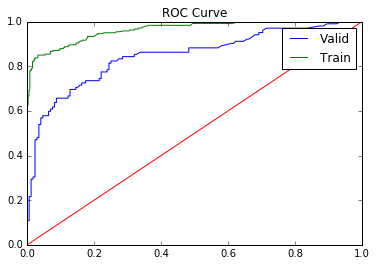

In [24]:
model_performance(gbm_model1)

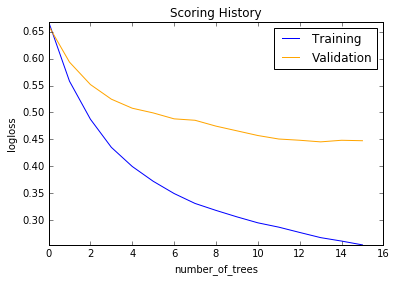

In [25]:
gbm_model1.plot()

In [26]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator

In [27]:
dl = H2ODeepLearningEstimator(seed =1,  hidden=[200,200], epochs =200, l2= 1e-25, 
                              activation = 'MaxoutWithDropout', distribution = 'AUTO')
dl.train(x =input_col, y = 'Survived', training_frame=hdf_train, validation_frame=hdf_validate)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


Train accuracy: 0.923585322723
valid accuracy: 0.859895120839


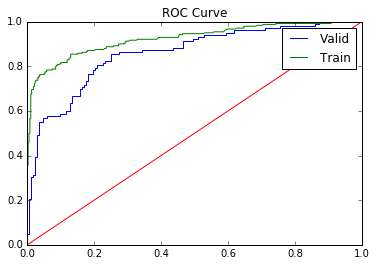

In [28]:
model_performance(dl)

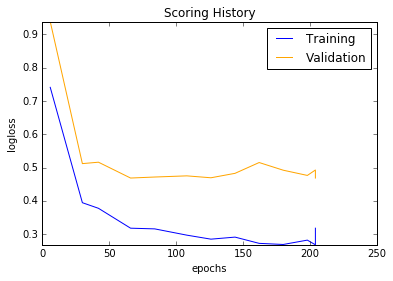

In [29]:
dl.plot()

## Predict with test data

In [30]:
df_test = pd.read_csv('F:/Titanic/data/test.csv')

replace_age_fraction(df_test)
replace_na_to_mode(df_test)

0
Pclass
Sex
Age
SibSp
Parch
Ticket
Fare
Cabin
Embarked


In [31]:
df_poly_test = pd.concat([polynomial_data(df_test,'Pclass',2), 
                 polynomial_data(df_test,'Age',5),
                 polynomial_data(df_test,'Fare',4), 
                 df_test], axis=1).head()

In [32]:
# df_poly_test.head()

In [33]:
hdf_test = h2o.H2OFrame(df_poly_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [34]:
def get_prediction(model= gbm_model, hdf_data = hdf_test, create_frame=True):
    prediction = model.predict(hdf_data)
    
    if(create_frame == True):
        lst_id=range(892,len(df_test['Age'])+892)

        #initialize dataframe and save prediction values in Survived columns and lst_id in Passenger id coloums
        df_submission = pd.DataFrame()
        df_submission['PassengerId'] = lst_id
        df_submission['Survived'] = prediction['predict'].as_data_frame()
        
        return df_submission

    else:
    #     prediction['predict'].unique()
        return prediction

In [38]:
df_submission = get_prediction(dl,hdf_data=hdf_test, create_frame=True)

deeplearning prediction progress: |███████████████████████████████████████| 100%


In [39]:
df_submission.to_csv('F:/Titanic/data/submission.csv',index=False)